In [ ]:
upsampling : 데이터를 두배로 늘려준다
subsample = (2, 2) : 2 회선으로 다운 샘플링

< GAN >

y = 1 / ( 1 + exp ⁡ ( − x ) ) ⟷ x = ln ⁡ ( y / ( 1 − y ) )


math.exp(1) = 2.718281828459045

math.exp(-1)= 0.36787944117144233

In [2]:
import tensorflow as tf
import numpy as np

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #sigmoid activation을 안함

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

real_output = np.array( [[ 0.1, 0.2], [0.3, 0.1]] )
fake_output = np.array( [[ 0.9, 0.8], [0.7, 0.8]] )

#real_output = np.array( [[ 0.9, 0.9], [0.9, 0.9]]  )
#fake_output = np.array( [[ 0.01, 0.02], [0.01, 0.03]])

print ("===",discriminator_loss(real_output, fake_output))

=== tf.Tensor(1.7819572687149048, shape=(), dtype=float64)


심층 합성곱 생성적 적대 신경망

- 훈련 과정동안 생성자는 점차 실제같은 이미지를 더 잘 생성하게 되고 식별자(감별자)는 점차 진짜와 가짜를 더 잘 구분하게 된다.
- 반복을 하다 보면 식별자가 가짜 이미지에서 진짜 이미지를 더 이상 구별하지 못할 때 평형 상태에 도달하게 된다.

In [3]:
import glob
import imageio
import numpy as np
import os
import PIL
import time
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from IPython import display
from keras.datasets import mnist

In [4]:
# minist.load_data()

(train_images, train_labels), (_, _) = mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = ( train_images - 127.5 ) / 127.5  # 이미지를 [-1, 1] 정규화 시킨다

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# 배치 데이터를 만들고 섞어보자
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

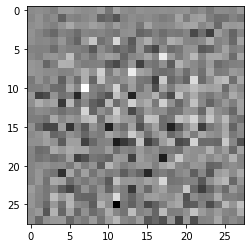

In [5]:
# 생성자 설정
def make_generator_model(): 
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 배치 사이즈로 None이 주어짐
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model 

# 생성자 확인  
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [6]:
# 판별자 설정
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]))
    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
              
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# 판별자 확인
# 판별자 모델 함수에 가짜 이미지를 입력해서 판별
# 결과가 0.00042554 0에 가까운 숫자가 출력되고 있어 가짜로 판별, 1이 되어야 진짜
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00132628]], shape=(1, 1), dtype=float32)


In [7]:
# 손실에 대한 헬퍼 함수 추가

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.zeros_like(fake_output), fake_output)


In [8]:
# 생성자 옵티마이저, 판별자 옵티마이저, 아담

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [9]:
# 학습 모델 저장

check_dir = './train_check'
check_prefix = os.path.join(check_dir, "ckpt")
checkpoint = tf.train.Checkpoint( generator_optimizer = generator_optimizer, 
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator, discriminator = discriminator                                 
                                )


In [10]:
# 노이즈 이미지 생성 코드

EPOCHS = 50
noise_dim = 100
num_examplt_to_generate = 16

seed = tf.random.normal([ num_examplt_to_generate, noise_dim ])

In [11]:
# 사용자 컴파일 함수를 만들자
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [12]:
# 12. 저장하기
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)   # 배치 정규화 모든 층들이 추론 모드가 된다.
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [13]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # 15 에포크가 지날 때마다 모델을 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
# 14. 테스트
train(train_dataset, EPOCHS)